# Content and Objective

+ Show estimation of psd w. Blackman-Tukey
+ Method: Get noise and filtered noise, and perform psd estimation

In [1]:
# importing
import numpy as np
from scipy import signal
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 30}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(30, 8) )

# Helper Functions

### Define Function for Estimating ACF

In [3]:
########################
# acf estimator
########################
def est_acf(y, est_type):
    """
    estimates acf given a number of observation
    
    Remark: signal is assumed to be starting from 0 to length(y)-1
    
    IN: observations y, est_type (biased / unbiased)
    OUT: estimated acf, centered around 0
    """
    
    N = np.size( y )
    r = np.zeros_like( y )
    
    # loop lags of acf
    for k in np.arange(0, N):
        
        temp = np.sum( y[k:N] * np.conjugate(y[0:(N-k)]) )

        # type of estimator
        if est_type == 'biased':
            r[k] = temp/N
        elif est_type == 'unbiased':
            r[k] = temp/(N-k)
        
    # find values for negative indices
    r_reverse = np.conjugate(r[::-1])     
   
    return  np.append(r_reverse[0:len(r)-1], r)  

### Functions for estimating psd 

In [4]:
########################
# periodogram estimator
########################
def find_periodogram(y, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    
    IN: observation y, frequencies
    OUT: psd estimator
    """
    N = len(y)
    per = np.zeros(len(omega), dtype=complex) 
        
    for p in np.arange(0, N):
        per += y[p] * np.exp( -1j * omega * (p+1) )
        
    per = ( abs(per)**2 )/ N
        
    return per  

########################
# correlogram estimator
########################
def find_correlogram(r, omega):
    """
    estimates correlogram out of the given acf at the frequencies specified in omega
    
    Remark: acf is assumed to be centered around 0
    
    IN: acf r, frequencies
    OUT: psd
    """
    corr = np.zeros(len(omega), dtype=complex )
  
    N = (len(r)+1)// 2
    
    # adding all terms
    for p in np.arange( -(N-1), (N-1)+1 ):
        corr += r[ p + (N-1) ] * np.exp( -1j * omega * p )

    # since there are minor numerical issues, resulting in negligible imaginary part, only real part is returned
    return np.real( corr )



########################
# Bartlett periodogram estimator
########################
def find_bartlett_estimate( y, M, omega):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    using Bartlett's method
    
    IN: observation y, group size M, frequencies Omega
    OUT: psd estimator
    """
    
    N = len(y)
    K = int( float(N)/M )
    
    per = np.zeros(len(omega) )
    
    k = 0
    while k<K:
        
        yk = y[ k*M : (k+1)*M ]         # mind that the upper limit is not included    
        Yk = find_periodogram( yk, omega )
        per = 1.0/(k+1) * ( k * per + Yk )  

        k += 1            

    return per



########################
# Welch periodogram estimator
########################
def find_welch_estimate(y, M, O, omega, window=[]):
    """
    estimates periodogram out of the given observation at the frequencies specified in omega
    using Welch's method
    
    IN: observation y, group size M, overlap O, frequencies Omega, 
        window of length M chosen as rect if not specified otherwise
    OUT: psd estimator
    """
    
    N = len(y)
    K = int( N / (M-O) )
    
    per = np.zeros(len(omega))
    
    if window==[]:
        window = np.ones(M)
    
    window = window / (1.0/M * np.sum(window**2))

    # loop for segments    
    k = 0
    while k<K-1:        
        yk = y[ k*(M-O) : (k*(M-O)+M) ] # mind that the upper limit is not included        
        yk = yk * window        
    

        
        Yk = find_periodogram(yk, omega)

        per = 1.0/(k+1) * ( k*per + Yk )  

        k += 1            

    return per  

# Parameters

In [5]:
# parameters: number of samples and according length of acf
N = int( 1e2 )
N_range = np.arange( 0, N )

# width of segments and overlap
M = N // 10
O = M // 2


# number of realizations for averaging    
N_real = int( 1e2 )

# number of freq. points and freq. range
N_freq = 512            
Ome = np.linspace(-np.pi, np.pi, N_freq)


# filtering noise?!
filtered = 1

### Define windows and choose

In [10]:
# define windows
rect = np.concatenate( ( np.zeros(N-M), np.ones( 2 * M ), np.zeros( N-1-M) ) )
tria = np.concatenate( ( np.zeros(N-M), signal.triang( 2 * M ), np.zeros( N-1-M) ) )
hann = np.concatenate( ( np.zeros(N-M), signal.hann( 2 * M ), np.zeros( N-1-M)) )
hamming = np.concatenate( ( np.zeros(N-M), signal.hamming( 2 * M ), np.zeros( N-1-M)) )    
blackman = np.concatenate( ( np.zeros( N-M), signal.blackman( 2 * M ), np.zeros( N-1-M)) ) 

# change window if you like
window = blackman

# Loop for realizations

In [19]:
# initialize arrays for psd
psd_noise_per = np.empty( [ N_real, N_freq ], dtype=float )
psd_noise_black = np.empty( [ N_real, N_freq ], dtype=float )
psd_noise_bart = np.empty( [ N_real, N_freq ], dtype=float )
psd_noise_welch = np.empty( [ N_real, N_freq ], dtype=float )


psd_sin_per = np.empty( [ N_real, N_freq ], dtype=float )
psd_sin_black = np.empty( [ N_real, N_freq ], dtype=float )
psd_sin_bart = np.empty( [ N_real, N_freq ], dtype=float )
psd_sin_welch = np.empty( [ N_real, N_freq ], dtype=float )



# avtivate parameter "filtered" in parameters if you like to see filtered noise
if filtered == 1:
    # filter parameters
    cutoff_freq = 1.0/4.0

    ripple_db = 60                      # ripples and transition width of the filter
    width = 1 / 5.0

    N_filter, beta = signal.kaiserord(ripple_db, width)    # find filter order and beta parameter
    
    taps = signal.firwin( N_filter, cutoff=cutoff_freq,  window=('kaiser', beta))

    
# loop for realizations
for _k in range( N_real ):
    
    # generate noise
    noise = np.sqrt(2) * np.random.normal( 0.0, 1.0, N )

    # activate to have filtered noise
    if filtered == 1:
        noise = signal.lfilter( taps, 1.0, noise )   
        noise /= np.linalg.norm( noise )

    # find acf estimations        
    acf_biased  = est_acf( noise, 'biased') 

    # find psd
    psd_noise_per[ _k, :] = find_periodogram( noise, Ome)      
    psd_noise_black[ _k, :] = find_correlogram( acf_biased * window, Ome)
    psd_noise_bart[ _k, :] = find_bartlett_estimate( noise, M, Ome)
    psd_noise_welch[ _k, :] = find_welch_estimate( noise, M, O, Ome)        

    
    # sinusoids
    Omega_0 = 1.0
    Omega_1 = 1.2
    y = np.sin( Omega_0 * N_range ) + np.sin( Omega_1 * N_range)  + np.random.normal(0.0, 1.0, size = N)

    # find acf estimations        
    acf_biased  = est_acf( y, 'biased') 
    
    psd_sin_per[ _k, :] = find_periodogram( y, Ome )      
    psd_sin_black[ _k, :] = find_correlogram( acf_biased * window, Ome)
    psd_sin_bart[ _k, :] = find_bartlett_estimate( y, M, Ome )  
    psd_sin_welch[ _k, :] = find_welch_estimate( y, M, O, Ome )  
    
    
# get mean and std along realizations
psd_noise_per_average = psd_noise_per.mean( axis=0 )  
psd_noise_black_average = psd_noise_black.mean( axis=0 )
psd_noise_bart_average = psd_noise_bart.mean( axis=0 )
psd_noise_welch_average = psd_noise_welch.mean( axis=0 )

psd_sin_per_average = psd_sin_per.mean( axis=0 )  
psd_sin_black_average = psd_sin_black.mean( axis=0 )
psd_sin_bart_average = psd_sin_bart.mean( axis=0 )
psd_sin_welch_average = psd_sin_welch.mean( axis=0 )

# Plotting

### show results for noise

Text(0, 0.5, '$\\hat{\\Phi}_W(\\Omega)$')

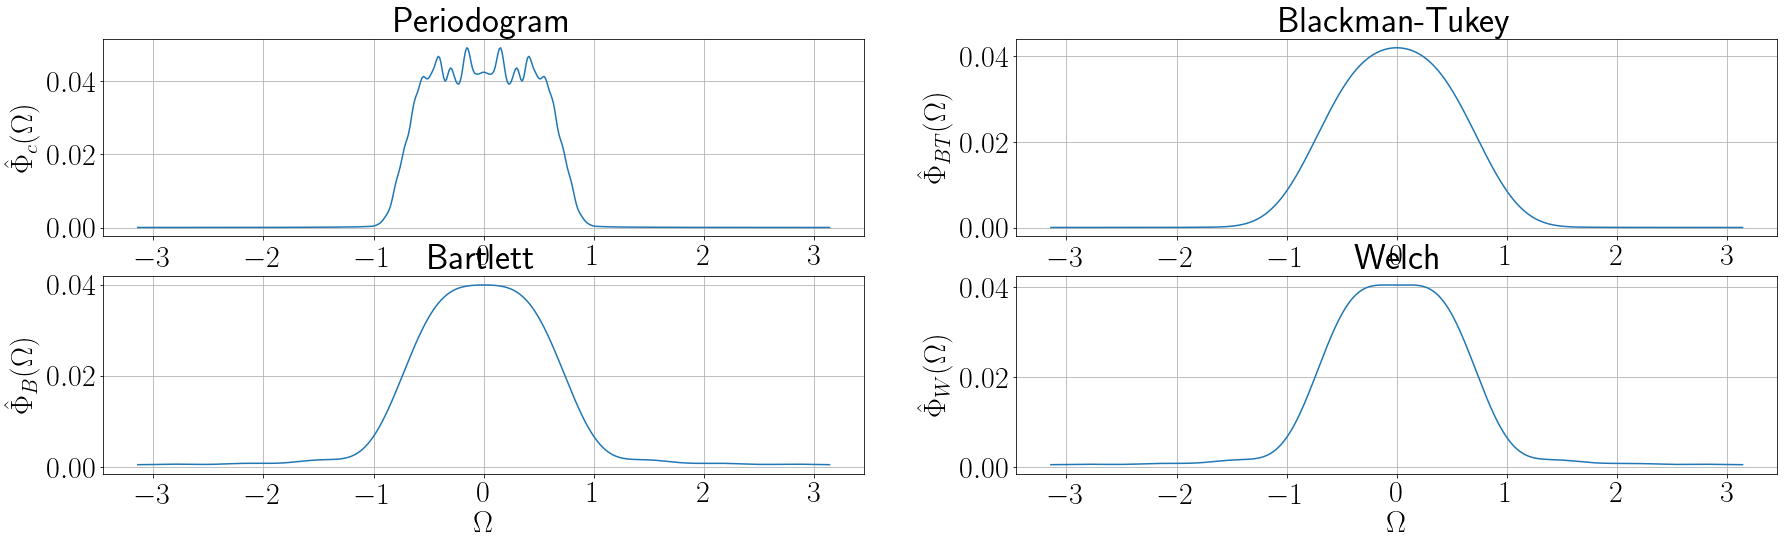

In [20]:
plt.subplot(221)    
plt.plot(Ome, psd_noise_per_average)      

plt.title('Periodogram')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_c(\Omega)$')   


plt.subplot(222)    
plt.plot(Ome, psd_noise_black_average)      

plt.title('Blackman-Tukey')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_{BT}(\Omega)$')   


plt.subplot(223)        
plt.plot(Ome, psd_noise_bart_average )

plt.title('Bartlett')    
plt.grid(True); 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_B(\Omega)$')   


plt.subplot(224)        
plt.plot(Ome, psd_noise_welch_average)      

plt.title('Welch')    
plt.grid(True); 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_W(\Omega)$')   


### show results for sinusoids

Text(0, 0.5, '$\\hat{\\Phi}_W(\\Omega)$')

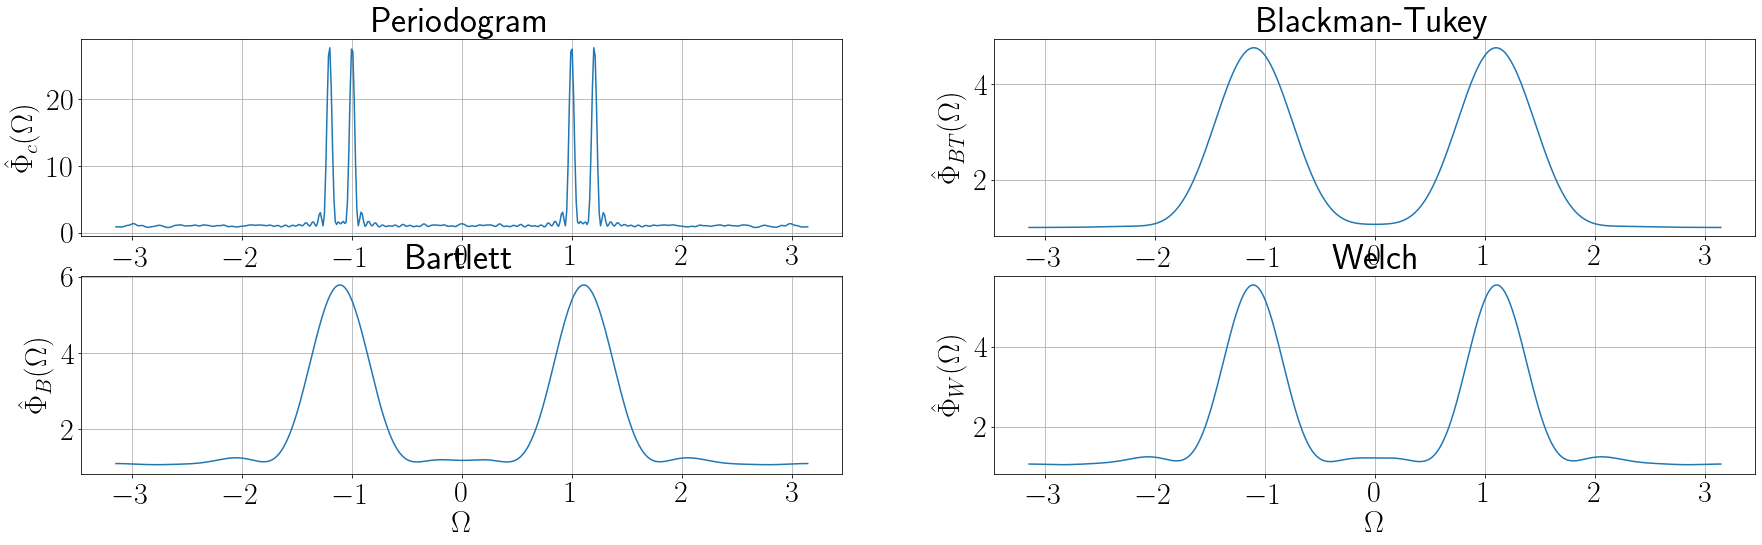

In [21]:
plt.subplot(221)    
plt.plot(Ome, psd_sin_per_average)      

plt.title('Periodogram')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_c(\Omega)$')   


plt.subplot(222)    
plt.plot(Ome, psd_sin_black_average)      

plt.title('Blackman-Tukey')    
plt.grid(True); 
plt.ylabel('$\hat{\Phi}_{BT}(\Omega)$')   


plt.subplot(223)        
plt.plot(Ome, psd_sin_bart_average )

plt.title('Bartlett')    
plt.grid(True); 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_B(\Omega)$')   


plt.subplot(224)        
plt.plot(Ome, psd_sin_welch_average)      

plt.title('Welch')    
plt.grid(True); 
plt.xlabel('$\Omega$'); plt.ylabel('$\hat{\Phi}_W(\Omega)$')   
